# Basics

This page describes the basic ways to set up a contraction and an explicit optimizer and defines some common terms.
The focus of `cotengra` is *exact contraction*. That is, taking a collection of tensors with indices described by a tensor network or einsum equation and then:

1. finding the best sequence of pairwise contractions that reduces them to a single output tensor
2. performing this contraction using a mix of `tensordot` and potentially `einsum` calls

```{note}
`cotengra` doesn't involve itself with building, modifying, simplifying or decomposing tensors and tensor networks etc.
```

The minimal information you need to describe such a contraction is:

* the index labels for each tensor
* the output index labels
* the size of each index

Here's a very small example of such information involving 4 tensors:

In [1]:
%config InlineBackend.figure_formats = ['svg']
import cotengra as ctg

inputs = [
    ("a", "b", "x"),
    ("b", "c", "d"),
    ("c", "e", "y"),
    ("e", "a", "d"),
]

output = ("x", "y")

size_dict = {"x": 2, "y": 3, "a": 4, "b": 5, "c": 6, "d": 7, "e": 8}

This is equivalent to describing an einsum equation and array shapes (such as for `numpy.einsum` or `opt_einsum.contract`):

In [2]:
import numpy as np

eq = "abx,bcd,cey,ead->xy"
shapes = [(4, 5, 2), (5, 6, 7), (6, 8, 3), (8, 4, 7)]
arrays = [np.ones(s) for s in shapes]

The actual names of indices here are only relevant for defining the *geometry*
within this contraction.

```{note}
For readability, generally a single unicode character is used per index.
See `ctg.get_symbol(i)` if you need to generate a usable set of these.
```

Each index can be thought of as an ***edge*** in a tensor network,
with each tensor being a ***node***. If every index appears exactly twice in either
the inputs or output, then the underlying geometry is described as a
[***graph***](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)),
otherwise it is a [***hypergraph***](https://en.wikipedia.org/wiki/Hypergraph).
You can visualize an input contraction with:

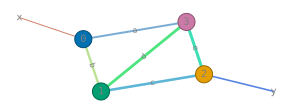

(<Figure size 500x500 with 1 Axes>, <Axes: >)

In [3]:
ctg.HyperGraph(inputs, output, size_dict).plot()

Usually one of these representations is very easy to produce, or a library like `quimb` will do it for you. In any case, the next step is to create an *optimizer*.

## `HyperOptimizer`

The main driver is the [`HyperOptimizer`](cotengra.hyper.HyperOptimizer) class, which optimizes a single contraction:

In [4]:
opt = ctg.HyperOptimizer()

The most flexible way to use this is to call the [`search`](cotengra.hyper.HyperOptimizer.search) method which directly returns a
[`ContractionTree`](cotengra.core.ContractionTree). This is a ***rooted
binary tree***:

In [5]:
# direct use
tree = opt.search(inputs, output, size_dict)
tree

<ContractionTree(N=4)>

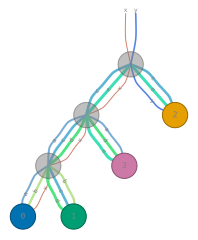

In [6]:
tree.plot_flat();

The tree (which also has the mathematical name,
['carving decomposition'](https://en.wikipedia.org/wiki/Branch-decomposition#Carving_width)) contains all the crucial information about costs and sizes of
intermediate tensors:

In [7]:
tree.contraction_width(), tree.contraction_cost()

(8.39231742277876, 4656)

* the ***contraction width***, $W$, is $log_2$ the size of the largest intermediate tensor
* the ***contraction cost***, $C$, is the total number of scalar multiplications

The tree can be used to perform the actual contraction too:

In [8]:
tree.contract(arrays)

array([[6720., 6720., 6720.],
       [6720., 6720., 6720.]])

A tree combined with a specific traversal ordering is known as a ***path***:

In [9]:
path = tree.get_path()
path

((0, 1), (1, 2), (0, 1))

Such paths can be supplied to `opt_einsum` and `quimb` functions, *or*
you can supply the [`HyperOptimizer`](cotengra.hyper.HyperOptimizer)
itself, in which case it will first run a search and then pass on a path.

#### With ``quimb``

In [10]:
import quimb.tensor as qtn

tn = qtn.TensorNetwork(
    [qtn.Tensor(array, inds) for array, inds in zip(arrays, inputs)]
)

tn.contract(..., optimize=ctg.HyperOptimizer())

Tensor(shape=(2, 3), inds=('x', 'y'), tags=oset([]))

Note for non-hyper graphs `quimb` will figure out the output indices for you,
else you will need to supply `output_inds`. `quimb` also knows how to return
the [`ContractionTree`](cotengra.core.ContractionTree) directly with:

In [11]:
tn.contraction_tree(path)

<ContractionTree(N=4)>

And many other methods and algorithms take a `optimize=path_or_optimizer` option.

#### With `opt_einsum`

You can supply a `path` or `HyperOptimizer` to all the functions of `opt_einsum`
which take an `optimize` kwarg:

In [12]:
import opt_einsum as oe

oe.contract(eq, *arrays, optimize=path)

array([[6720., 6720., 6720.],
       [6720., 6720., 6720.]])

```{hint}
For convenience `cotengra` also registers a few presets which can be used like `optimize='hyper'`, these can also be created.
```

A single [`HyperOptimizer`](cotengra.hyper.HyperOptimizer) instance can only be used for a single contraction - everytime you supply it, as long as the contraction matches, it will simply continue it's search.

## `ReusableHyperOptimizer`

Often, instead you want a single optimizer with maybe customized settings to use for many different contractions - the answer is to use a [`ReusableHyperOptimizer`](cotengra.hyper.ReusableHyperOptimizer).
Everytime this is supplied to a *new* contraction it runs a search and stores the resulting path. The next time it sees this contraction it simply returns this cached path.

In [13]:
opt = ctg.ReusableHyperOptimizer(progbar=True)

In [14]:
opt.search(inputs, output, size_dict)

F=3.67 C=4.51 S=8.39 P=9.90: 100%|██████████| 128/128 [00:01<00:00, 82.14it/s]


<ContractionTree(N=4)>

In [15]:
opt.search(inputs, output, size_dict)

<ContractionTree(N=4)>

Note how the second call didn't display a progress bar as it used the cached result.

```{hint}
The contractions are not cached using full (hyper) graph isomoprhism, which would not be scalable. Instead, the inputs have to be in the same order to produce the same hash key.
```

### Disk persistence

If you want to persist contraction paths across python sessions (i.e. don't want to explicitly save the `tree` or `path` objects yourself), then you can supply the `directory` kwarg:

In [16]:
opt = ctg.ReusableHyperOptimizer(directory="cotengra_cache")

In [17]:
opt.search(inputs, output, size_dict)

<ContractionTree(N=4)>

The directory contains sharded structure with single pickled file per contraction it has seen:

In [18]:
!ls cotengra_cache/

04


In [19]:
# clean it up for now
!rm -rf cotengra_cache/

If you supply `directory=True` then the cache name will be generated from a
hash of the relevant path finding options supplied to the optimizer, meaning
you don't need to manually change the name in order to use different caches
for different settings.

## What next?

* The ['Advanced'](advanced) page, describes how to customize a [`HyperOptimizer`](cotengra.hyper.HyperOptimizer) in detail, for example to include subtree reconfiguration and dynamic slicing
* The ['Visualization'](visualization) page details many functions for plotting the contraction, tree and optimizer trials
* The ['Contraction'](contraction) page contains more information about actually performing the contraction, for example using a GPU
* The ['Tree Surgery'](trees) page describes the design of the central [`ContractionTree`](cotengra.core.ContractionTree) object and ways to manipulate it

## Quick-start

If you just want to get going, the following illustrate some common customizations of the optimizers.

### High quality sliced optimizer

The following is an example of a high quality optimizer you might use to search
for a single contraction, where you are memory bound to width $W=30$ and thus
need to use slicing:

In [20]:
opt_hq_W30 = ctg.HyperOptimizer(
    # do extra runs
    max_repeats=1024,
    # use dynamic slicing to target a width of 30
    slicing_reconf_opts={"target_size": 2**30},
    # use the cmaes space searcher - good with large trial budget
    optlib="cmaes",
    # terminate search if no change for 128 trials
    max_time="equil:128",
    # show live progress
    progbar=True,
)

* Everytime you supply this optimizer instance it will *continue* its search, so you
can interactively run it until you are happy or it seems to have converged.

* While a few hundred runs is usually sufficient when no slicing is needed, very large contractions requiring heavy slicing might benefit from a few thousand runs.

### Economical optimizer

The following is an example of a reusable optimizer that is cheap to run and
requires no extra depedencies (i.e. `kahypar` or a Bayesian optimizer),
but will still yield much better results than simple algorithms.
Useful if you have many smallish contractions:

In [21]:
opt_eco = ctg.ReusableHyperOptimizer(
    # just do a few runs
    max_repeats=32,
    # only use the basic greedy optimizer ...
    methods=["greedy"],
    # ... but pair it with reconfiguration
    reconf_opts={},
    # just uniformly sample the space
    optlib="random",
    # terminate search if contraction is cheap
    max_time="rate:1e6",
    # account for both flops and write - usually wise for practical performance
    minimize="combo-64",
    # persist paths found in here
    directory="cotengra_cache_eco",
)

An even faster option if one doesn't need slicing or to specific the `minimize` objective function is the `ReusableRandomGreedyOptimizer` which still provides good results but can run extremely quickly (especially if `cotengrust` is installed):

In [22]:
opt_rg = ctg.ReusableRandomGreedyOptimizer()

In [23]:
# clean up the cache for now
!rm -rf cotengra_cache_eco